In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

plt.rcParams['xtick.major.size'] = 1.2  # length of major xticks
plt.rcParams['xtick.major.width'] = 0.5   # width of major xticks
plt.rcParams['ytick.major.size'] = 1.2  # length of major yticks
plt.rcParams['ytick.major.width'] = 0.5   # width of major yticks


# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
from matplotlib.colors import LogNorm

from sparrow.predictors import batch_predict


Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


In [2]:
from finches.utils import folded_domain_utils
import mdtraj as md

In [3]:
from finches import Mpipi_frontend
from finches  import CALVADOS_frontend
mf = Mpipi_frontend()
cf = CALVADOS_frontend()

/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [4]:
# clean up so numbering is easy
RECLEAN_NUMBERS = False

if RECLEAN_NUMBERS:
    folded_domain_utils.extract_and_write_domains('ABD_frame0.pdb', 'ABD_frame0_renumbered.pdb', start=0, end=80)

In [10]:
# load in a folded structure of Gal11 (158-238)
FD = folded_domain_utils.FoldeDomain('ABD_frame0_renumbered.pdb',surface_thresh=0.1, sasa_mode='v1')

FD.write_SASA_vis_file('ABD_sasa.txt')

# Parse SANBORN raw data
Important - we want to build a dictionary called `raw_data_sb` where keys are unique tile keys and values is a list where element 0 = sequence and element 1 = ADScore.

In [6]:
with open('sanborn_raw_no_reps.csv', 'r') as fh:
    content = fh.readlines()
    
raw_data_sb = {}
for line in content[1:]:
    tmp = []
    entry = line.strip().split(',')    
    name = entry[0]
    seq = entry[1]

    try:
        score = float(entry[-1])
    except Exception:
        print(f'Skipping line: {line}')
        pass

    try:    
        raw_data_sb[name] = [seq,score]        
    except Exception:        
        pass

Skipping line: A_nonnuclear_P32660:545,SRELNFSVVINFVLLFILCFVSGIANGVYYDKKGRSRFSYEFGTIAGSAATNG,,,,

Skipping line: A_tiles_P05085:207,GVPPTPNLLDYDWNNLNITGYEWISSELRDDALLSAVTLQGHHLGHTQPQEIS,ARG81,P05085,207,

Skipping line: A_tiles_P05085:388,VHGLARFLLNHYFNNVADKMTVVVLEKNPWKTLYFPRALMALGDLAGLGQSSN,ARG81,P05085,388,

Skipping line: A_tiles_P07261:116,NPLLYIQNQNPNSNSSVKVSRSQTFEPSKELIDLVFPWLSYLKQDMLLIDRTN,GCR1,P07261,116,

Skipping line: A_tiles_P0CE41:1281,SPKPSNGLSSVQPLLSSFSMNQLNGGTIPTVPSLTNITSQMGALPSLDRITTN,HAP1,P0CE41,1281,

Skipping line: A_tiles_P0CE41:362,KDETPSPFSTKAMIDHNKHTMNPPQSKCPVDHRNYMKDYPSDMANSSSNPASR,HAP1,P0CE41,362,

Skipping line: A_tiles_P0CE41:543,LPKLSDSCNLGILIIILRLTWLSIPSNSCEVDLGEESGSFLVPNESSNMSASA,HAP1,P0CE41,543,

Skipping line: A_tiles_P10961:377,ENMMARERHRTQQQALEKMFRFLTSIVPHLDPKMIMDGLGDPKVNNEKLNSAN,HSF1,P10961,377,

Skipping line: A_tiles_P10961:624,ESDLFWDNVHRNIDEQDARLQNLENMVHILSPGYPNKSFNNKTSSTNTNSNME,HSF1,P10961,624,

Skipping line: A_tiles_P12383:270,SPFQFLSLQGIGKCFQ

## Build true vs. false positive sets
For different threshold of what it means to be a "strong" activation domain or not, stratify the data so we collect together sequences associated with binary classification (strong vs. weak) where the definition of strong vs. weak is systematically varied.

In [8]:
all_sb_true =  {}
all_sb_false = {}

THRESHOLDS = np.arange(1,80,2.5)

for thresh in THRESHOLDS:

    sb_true = []
    sb_false = []    

    
    for name in raw_data_sb:
        i = raw_data_sb[name]
        if i[1] > thresh:
            sb_true.append(i[0])
           
        else:
            sb_false.append(i[0])
    
    all_sb_true[thresh] = sb_true
    all_sb_false[thresh] = sb_false           

In [11]:
# if computing de novo - takes ~2.5 min over 7577 ADs...
RECOMPUTE = False
SAVE = False

if RECOMPUTE:

    
    sanborn_attractive = {}
    sanborn_repulsive = {}
    sanborn_self = {}
    for k in tqdm(raw_data_sb):
        seq = raw_data_sb[k][0]
        sanborn_attractive[k] = FD.calculate_attractive_surface_epsilon(seq, cf.IMC_object)
        sanborn_repulsive[k] = FD.calculate_repulsive_surface_epsilon(seq, cf.IMC_object)
        sanborn_self[k] = cf.epsilon(seq,seq)
    if SAVE:
        with open('sanborn_attractive_safe.pickle', 'wb') as file:    
            pickle.dump(sanborn_attractive, file)
        with open('sanborn_repulsive_safe.pickle', 'wb') as file:    
            pickle.dump(sanborn_repulsive, file)
        with open('sanborn_self_safe.pickle', 'wb') as file:    
            pickle.dump(sanborn_self, file)



else:
    with open('sanborn_attractive.pickle', 'rb') as file:    
        sanborn_attractive = pickle.load(file)
    
    with open('sanborn_repulsive.pickle', 'rb') as file:    
        sanborn_repulsive = pickle.load(file)

    with open('sanborn_self.pickle', 'rb') as file:    
        sanborn_self = pickle.load(file)



# calculate summed value (note we could also investigate attractive valency by also account 
# for number of favourable interaction hits
sanborn_attractive_sum = {}
sanborn_repulsive_sum = {}
for k in sanborn_attractive:
    sanborn_attractive_sum[k] = np.sum(sanborn_attractive[k])
    sanborn_repulsive_sum[k]  = np.sum(sanborn_repulsive[k])
    
    

In [12]:


all_hits = {}
all_misses = {}

all_hits_eps = {}
all_misses_eps = {}


# for each possible threshold
for t in THRESHOLDS:

    hits = []
    misses = []
    
    hits_eps = []
    misses_eps = []

    # for each sequennce
    for k in raw_data_sb:
        seq = raw_data_sb[k][0]

        # if that sequence is a "strong AD" based on the current threshold
        if seq in all_sb_true[t]:

            # get the attractive epsilon sum associated with this sequence        
            hits.append(sanborn_attractive_sum[k])
            hits_eps.append(sanborn_self[k])
        else:

            # otherwise get the 
            misses.append(sanborn_attractive_sum[k])
            misses_eps.append(sanborn_self[k])
    all_hits[t] = hits
    all_misses[t] = misses

    all_hits_eps[t] = hits
    all_misses_eps[t] = misses


In [13]:

# create activation domain data ordered on AD score (smalles 1st) just so we can easily plot with
# on scatter plot!
ordered_ad = dict(sorted(raw_data_sb.items(), key=lambda item: item[1][1]))
ad_scores = [ordered_ad[i][1] for i in ordered_ad]
attractive_tmp = [sanborn_attractive_sum[i] for i in ordered_ad]
repulsive_tmp = [sanborn_repulsive_sum[i] for i in ordered_ad]
self_tmp = [sanborn_self[i] for i in ordered_ad]





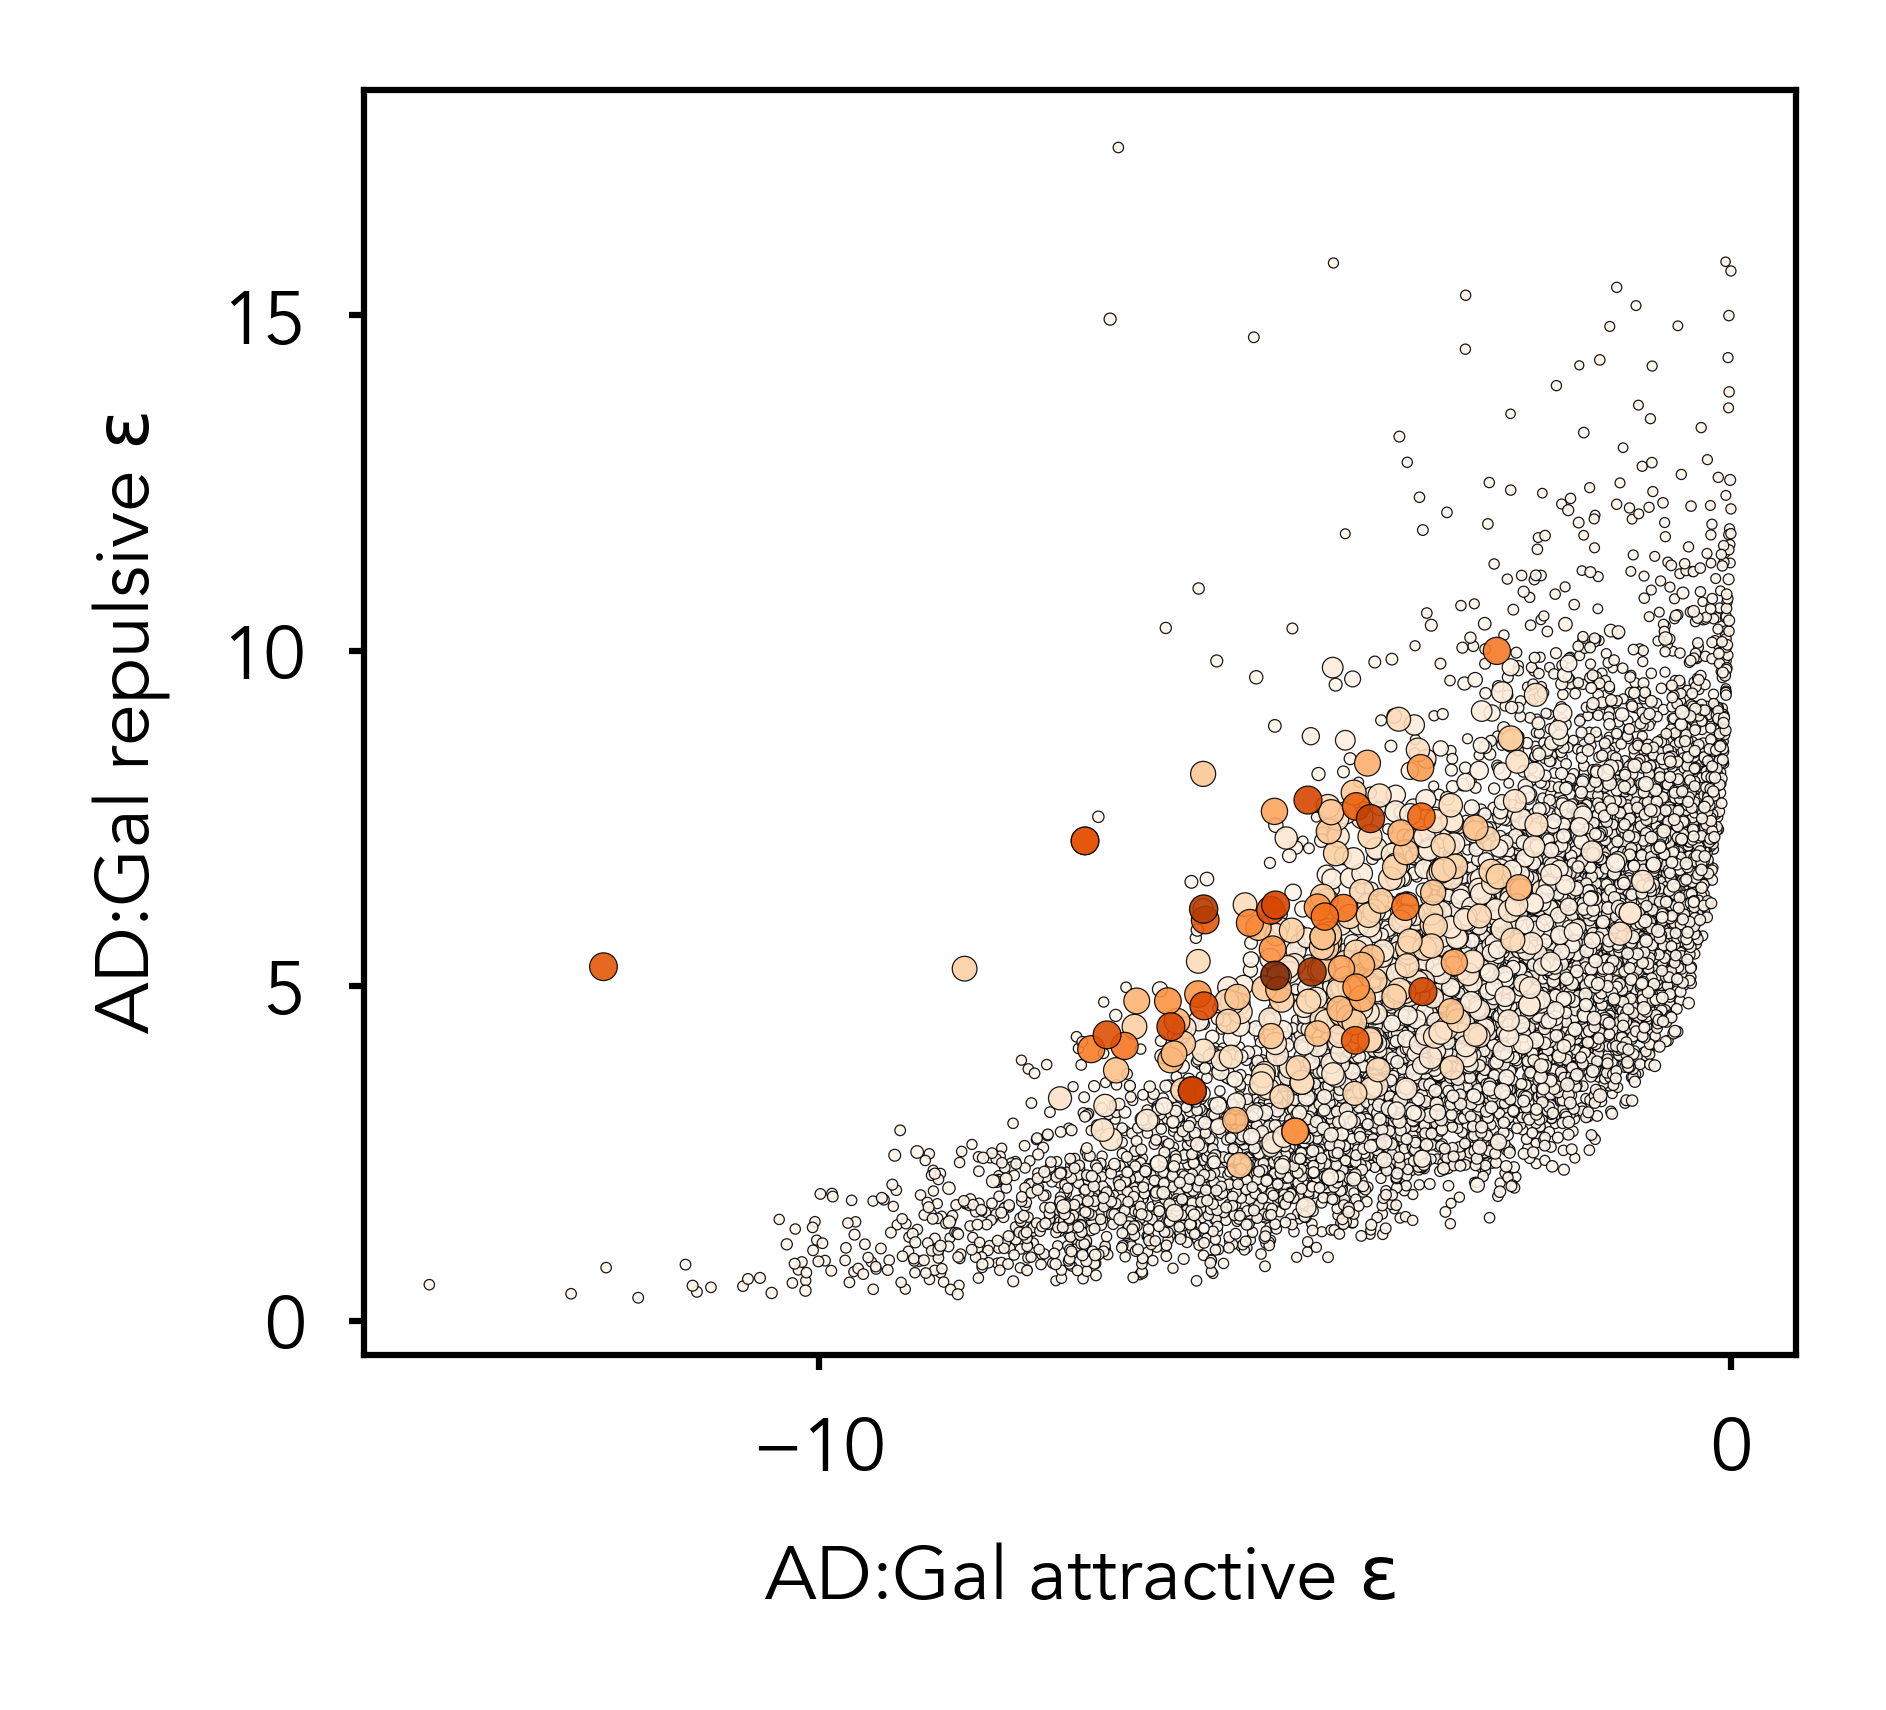

In [14]:
fig = plt.figure(figsize=(2.2, 2.), dpi=450)
ax = plt.gca()
plt.scatter(attractive_tmp, 
            repulsive_tmp, 
            c=ad_scores, 
            s=np.maximum(np.log(np.array(ad_scores)+1), 0.01), 
            cmap='Oranges', 
            linewidth=0.1, 
            edgecolors='k', 
            alpha=0.9)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel(r'AD:Gal attractive $\rm \epsilon$', fontsize=6)
plt.ylabel(r'AD:Gal repulsive $\rm \epsilon$', fontsize=6)



plt.tight_layout()
plt.savefig('out_figures/sanborn_att_rep_ad_score.pdf')


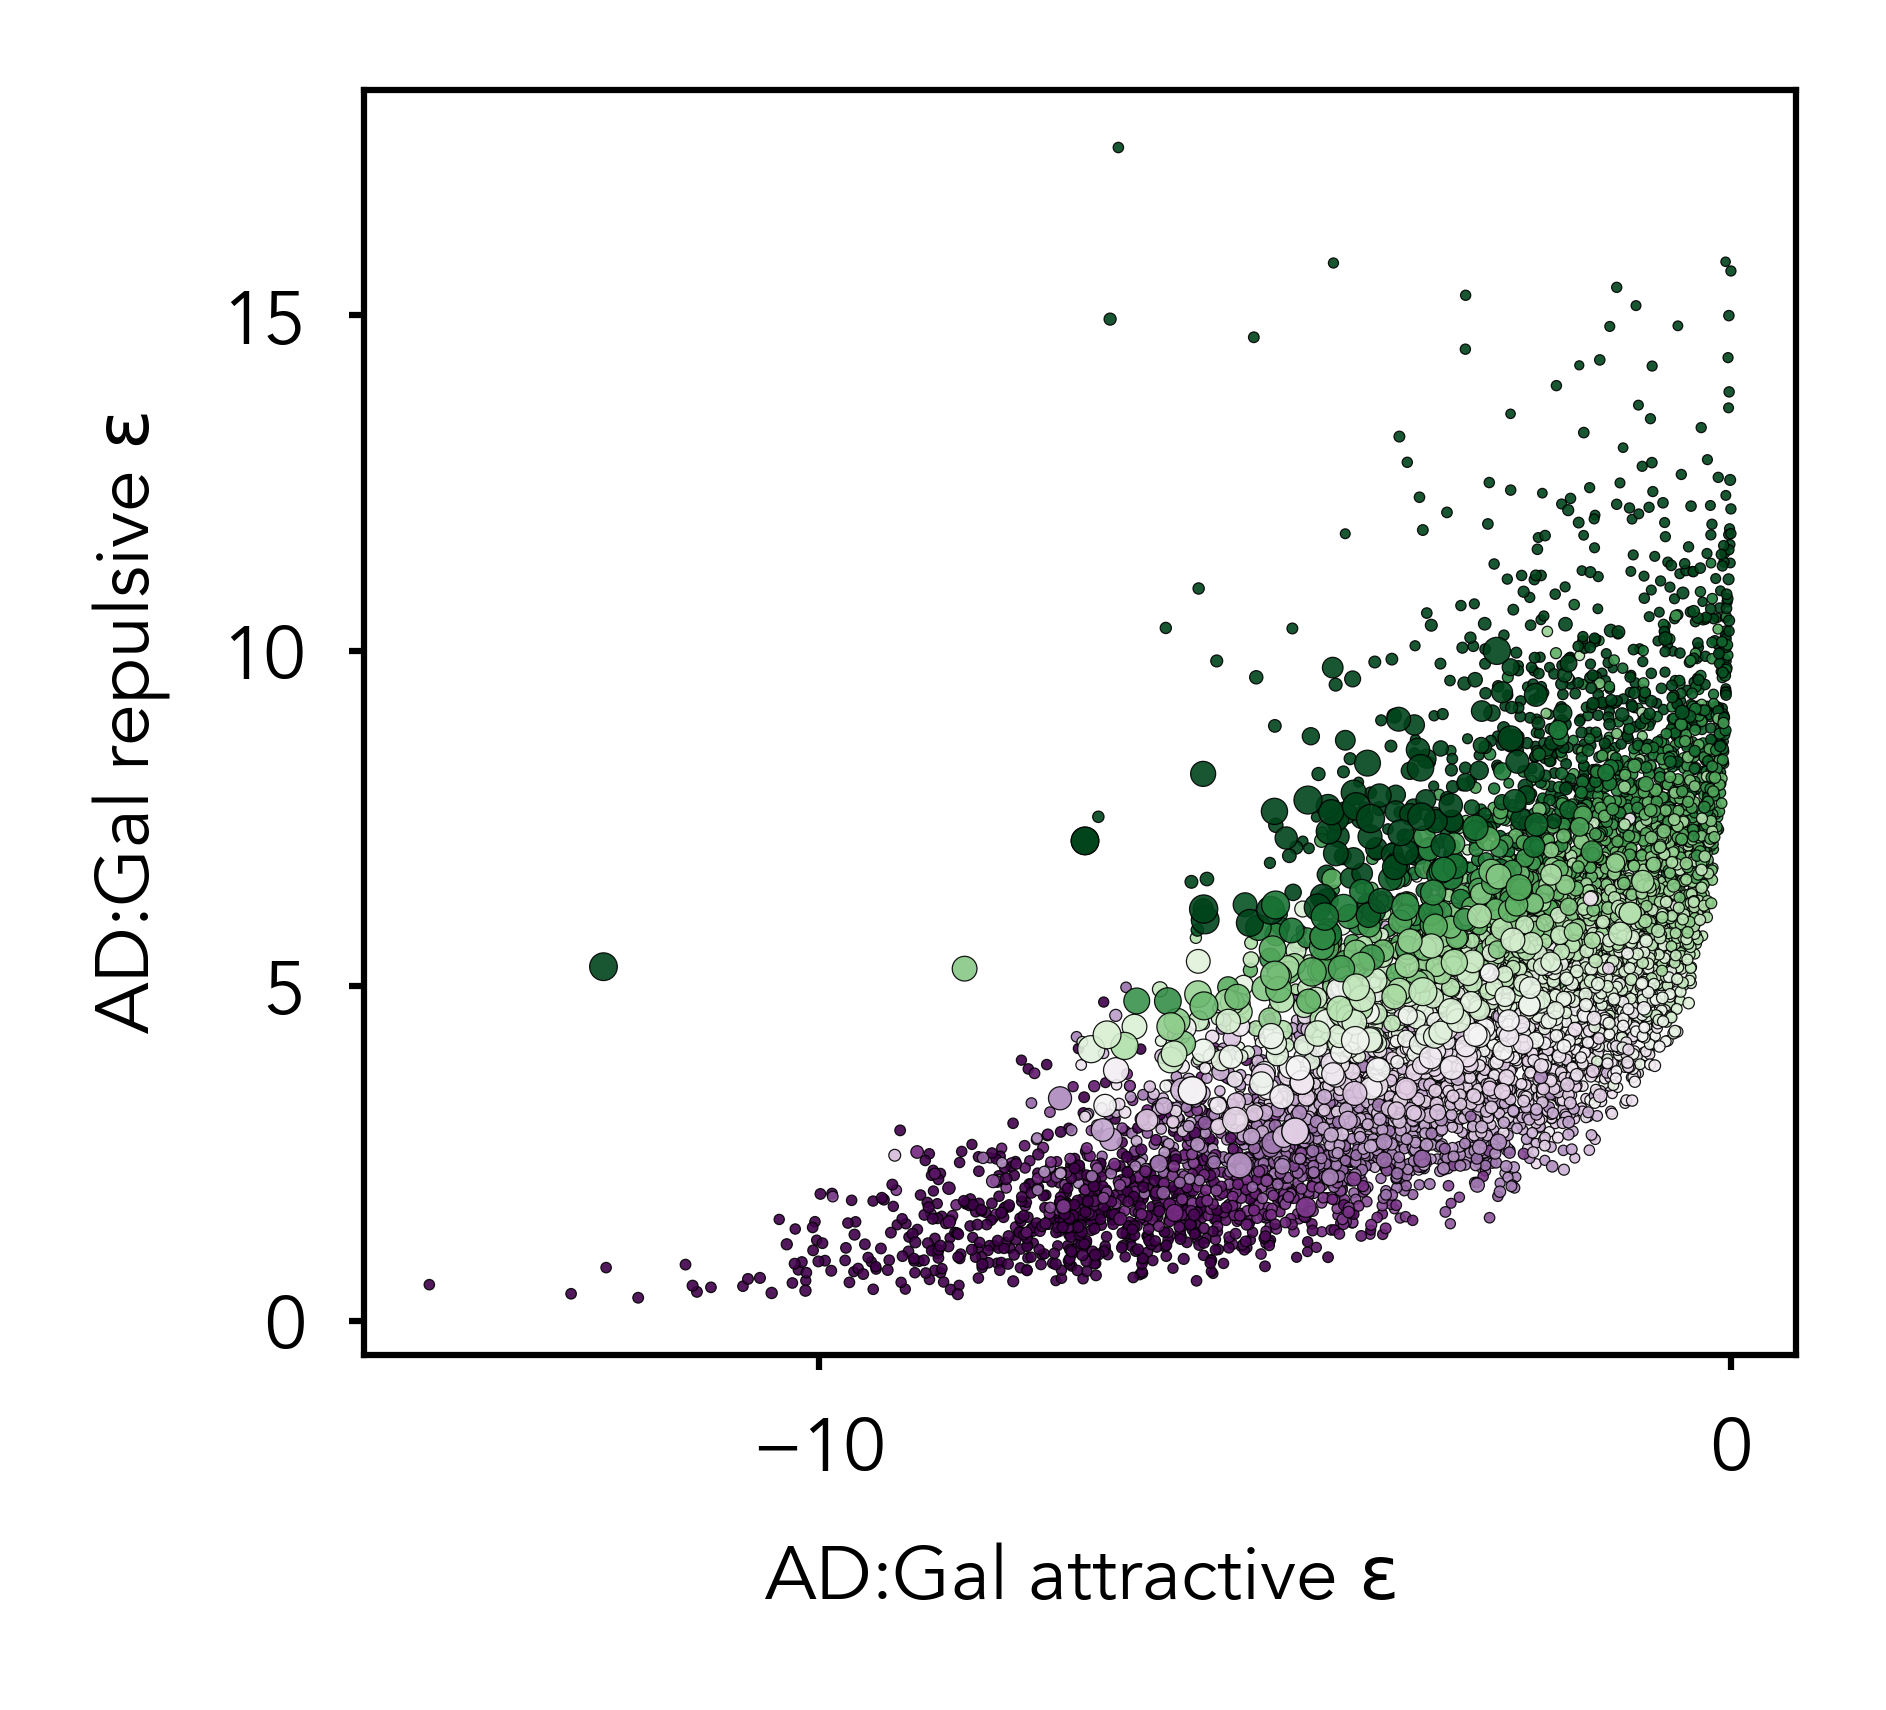

In [15]:
fig = plt.figure(figsize=(2.2, 2.), dpi=450)
ax = plt.gca()

plt.scatter(attractive_tmp, 
            repulsive_tmp, 
            c=self_tmp, 
            s=np.maximum(np.log(np.array(ad_scores)+1), 0.01), 
            cmap='PRGn', 
            linewidth=0.1, 
            edgecolors='k', 
            alpha=0.9, 
            vmin=-10, 
            vmax=10)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel(r'AD:Gal attractive $\rm \epsilon$', fontsize=6)
plt.ylabel(r'AD:Gal repulsive $\rm \epsilon$', fontsize=6)

plt.tight_layout()
plt.savefig('out_figures/sanborn_att_rep_self_interaction.pdf')



In [16]:
mean_hit_scores = []
std_hit_score = []
mean_miss_scores = []

for t in THRESHOLDS:
    mean_hit_scores.append(np.mean(all_hits[t]))
    mean_miss_scores.append(np.mean(all_misses[t]))
    std_hit_score.append(np.std(all_hits[t]))

Pearson -0.9443637401670041


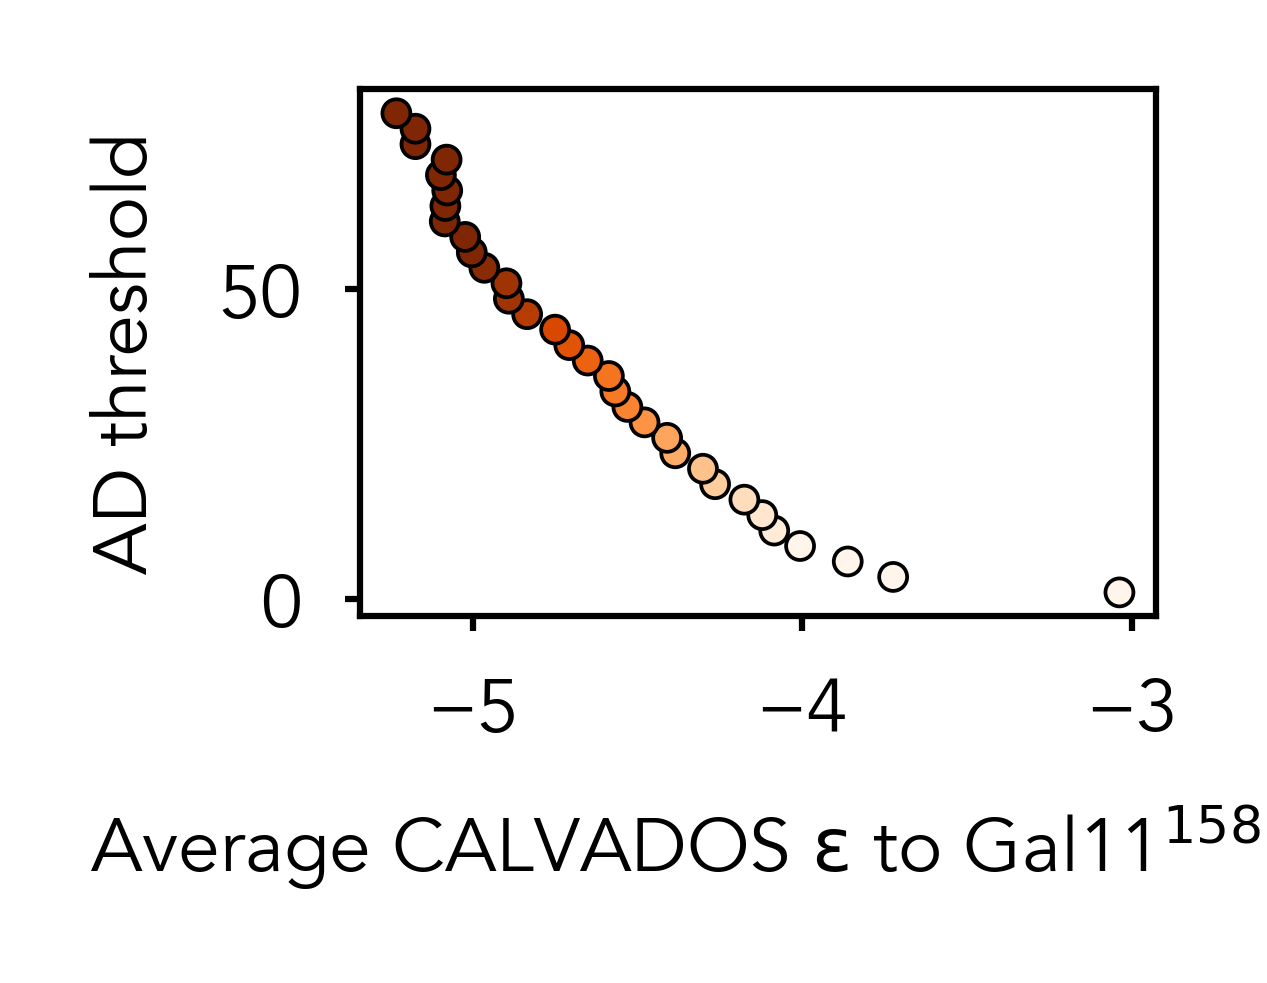

In [17]:
fig = plt.figure(figsize=(1.5, 1.2), dpi=450)
ax = plt.gca()

plt.scatter(mean_hit_scores, THRESHOLDS, c=mean_hit_scores, cmap='Oranges_r',s=5, edgecolor='k',linewidth=0.3, vmin=-5, vmax=-4)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel(r'Average CALVADOS $\rm \epsilon$ to Gal11$^{158-238}$',fontsize=6)
plt.ylabel('AD threshold',fontsize=6)
rho = np.corrcoef(mean_hit_scores,THRESHOLDS)[0][1]
print(f'Pearson {rho}')


plt.tight_layout()
plt.savefig('out_figures/ad_thresh_vs_interaction.pdf')







In [18]:
def get_score(k, attractive_thresh, repulsive_thresh, self_thresh):
    """
    Internal function which returns the AD score associated with 
    sequence mapped to index k assuming that:

        * attractive_sum[k] <  attractive_thresh (i.e. MORE favourable)
        * repulsive_sum[k] <  repulsive_thresh (i.e. LESS repulsive)
        * sanborn_self[k] > self_thresh (i.e. LESS self association)

    NOTE this function is a closure around the following dicts:

        raw_data_sb
        sanborn_attractive_sum
        sanborn_repulsive_sum
        sanborn_self

    Parameters
    ------------
    float or False
        If the value falls in the requested range returns the value,
        otherwise returns False

    :

    """
    if sanborn_attractive_sum[k] < attractive_thresh:
        if sanborn_repulsive_sum[k] < repulsive_thresh:
            if sanborn_self[k] > self_thresh:
                return raw_data_sb[k][1]
    else:
        return False


100%|██████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.86it/s]


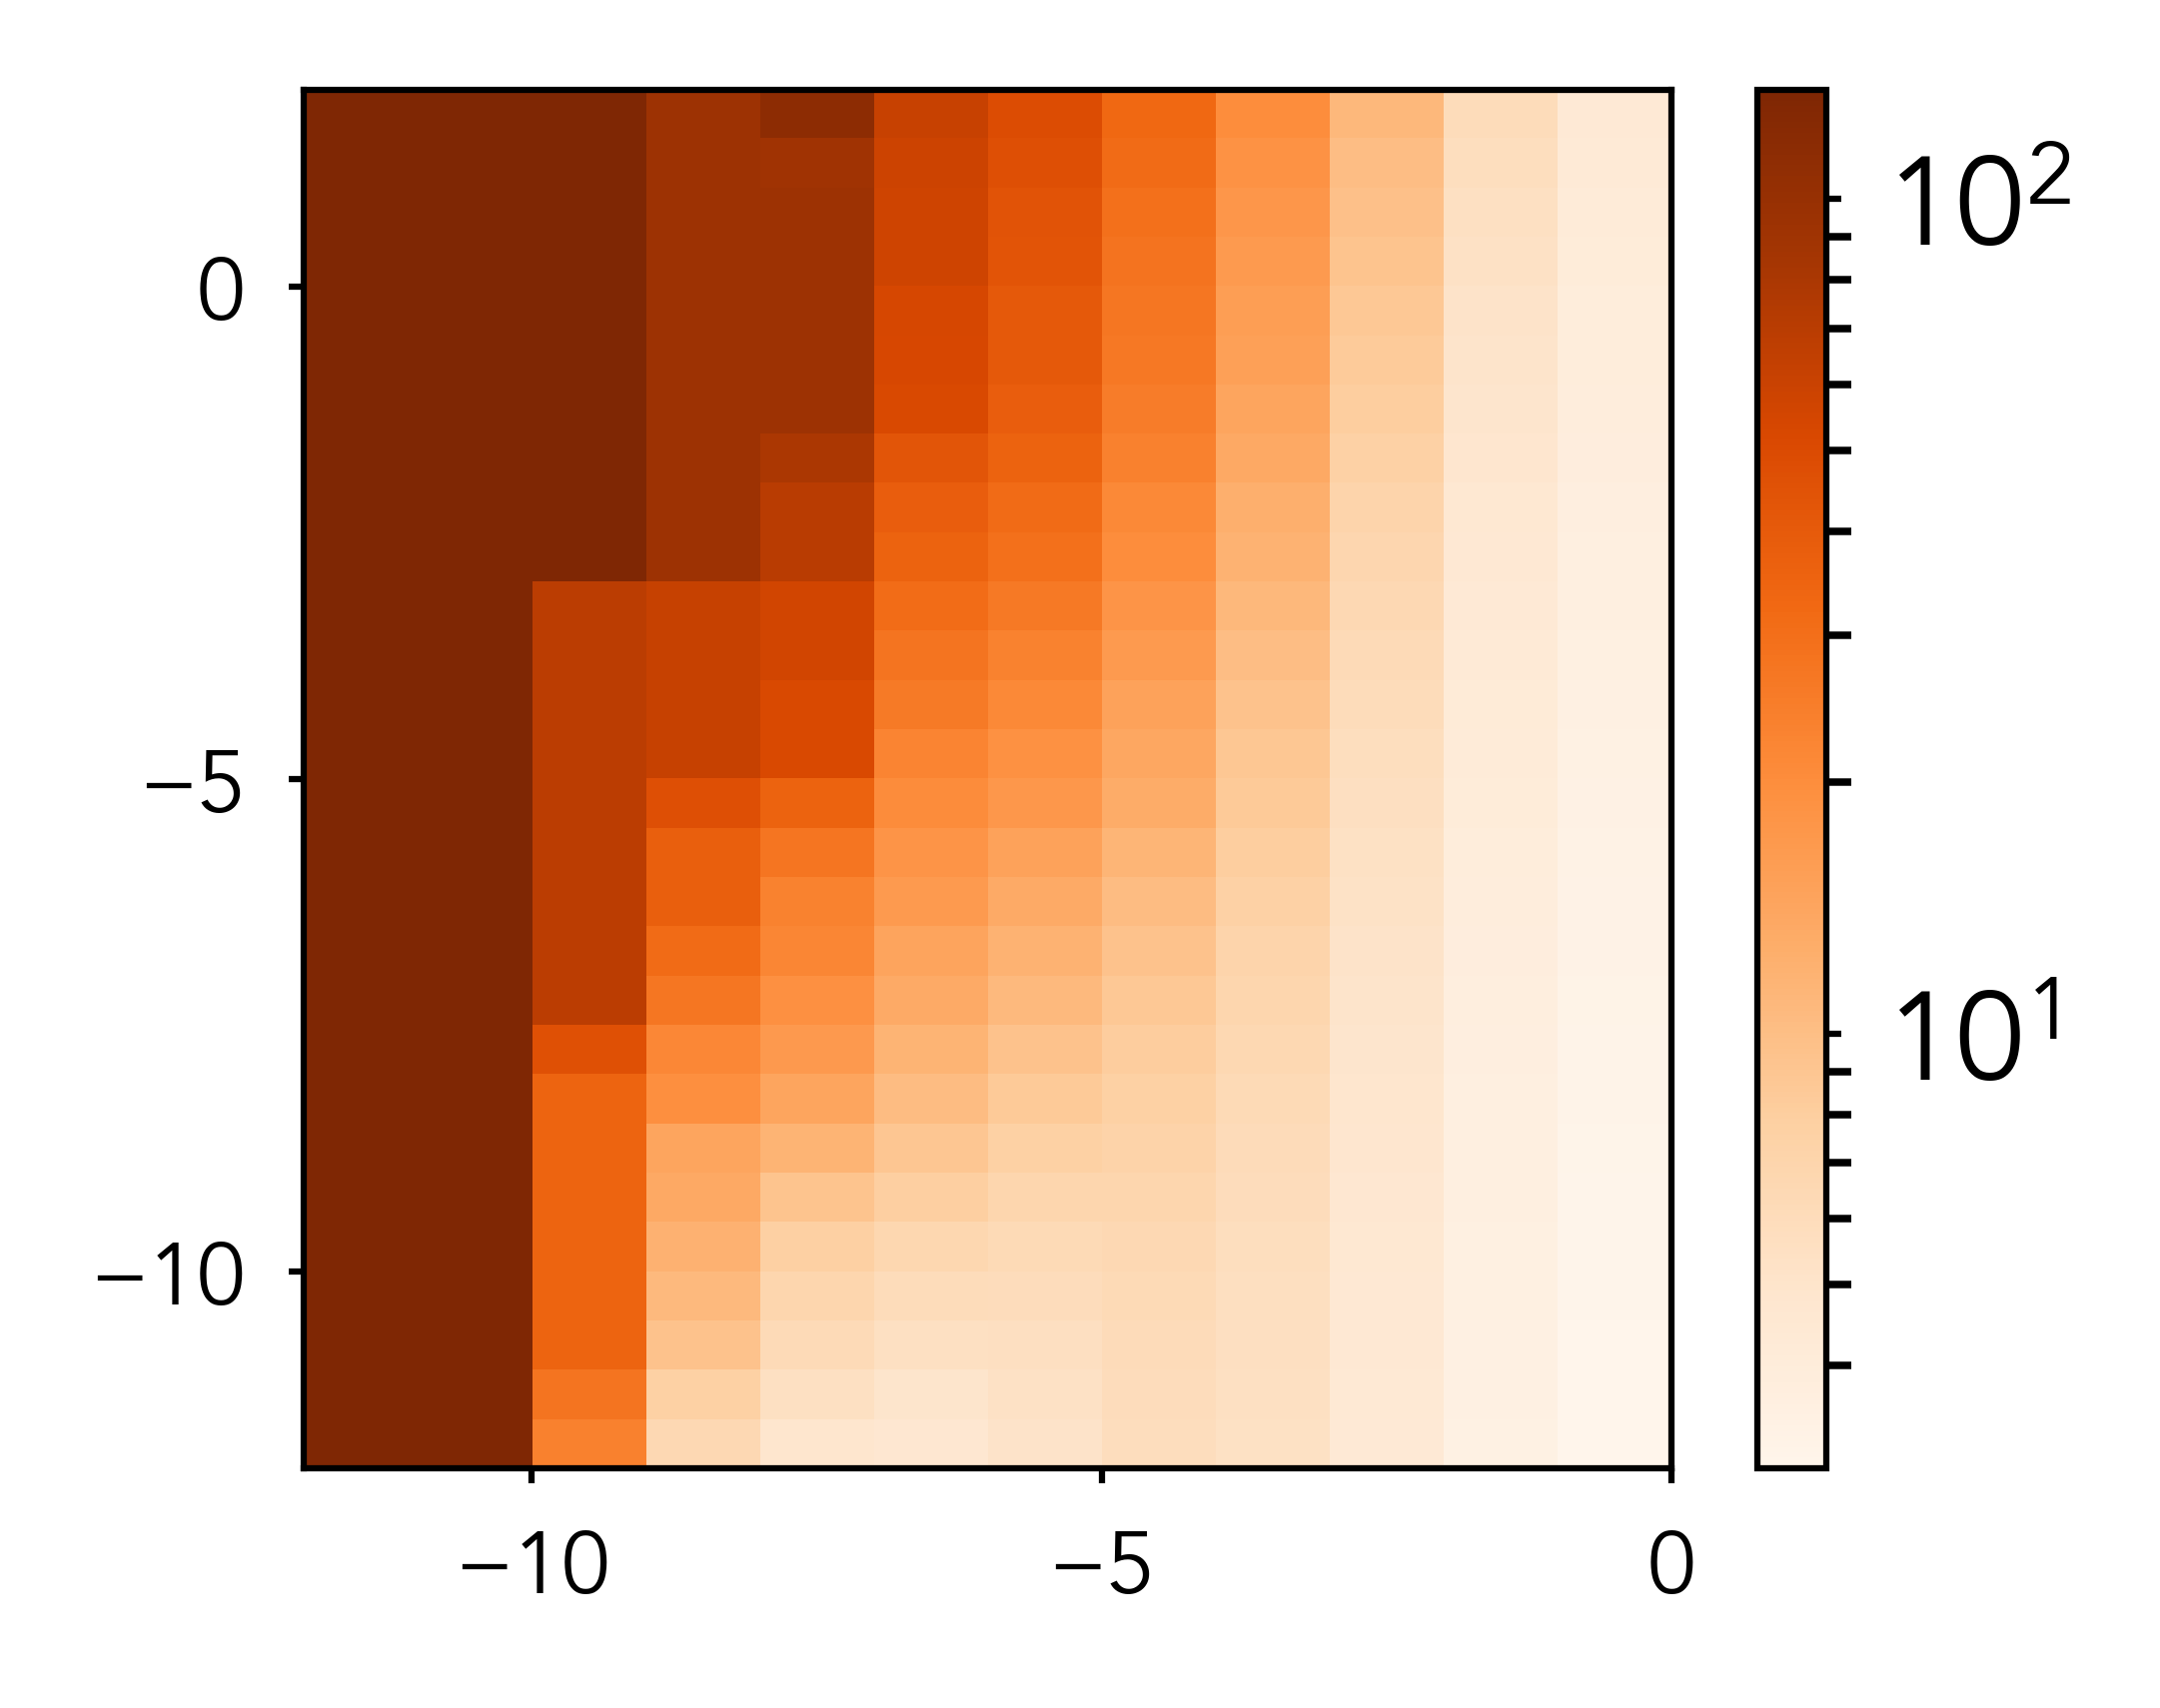

In [19]:


all_scores = []
all_counts = []
max_repulsion_thresh = 1000 # big value so is irrelevant
for at_thresh in tqdm(np.arange(0,-12,-1)):
    local_scores = []
    local_counts = []
    for self_thresh in np.arange(2,-12,-0.5):

        tst = []
        for k in raw_data_sb:
            s = get_score(k, at_thresh, max_repulsion_thresh, self_thresh)
            if s:
                tst.append(s)
        local_scores.append(np.mean(tst))
        local_counts.append(len(tst))
    all_scores.append(local_scores)
    all_counts.append(local_counts)

all_scores = np.array(all_scores)
fig = plt.figure(figsize=(2.5, 2.), dpi=450)
plt.imshow(all_scores.T,extent=[0,-12,2,-12], origin='lower', aspect='auto', cmap='Oranges', norm=LogNorm(vmin=all_scores.min(), vmax=all_scores.max()))
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
ax = plt.gca()
ax.invert_xaxis()
ax.invert_yaxis()


plt.colorbar()

plt.tight_layout()
plt.savefig('out_figures/heatmap_ad.pdf')
